# Eight schools

The eight schools problem ([Rubin 1981](https://www.jstor.org/stable/1164617)) considers the effectiveness of SAT coaching programs conducted in parallel at eight schools. It has become a classic problem ([Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/), [Stan](https://github.com/stan-dev/rstan/wiki/RStan-Getting-Started)) that illustrates the usefulness of hierarchical modeling for sharing information between exchangeable groups.

The Edward2 implemention below is an adaptation of an Edward 1.0 [tutorial](https://github.com/blei-lab/edward/blob/master/notebooks/eight_schools.ipynb).  

# Imports

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
import warnings

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

[Eager execution](https://www.tensorflow.org/get_started/eager) can also be used by running `tf.enable_eager_execution()` above.

# The Data

From Bayesian Data Analysis, section 5.5 (Gelman et al. 2013):

> *A study was performed for the Educational Testing Service to analyze the effects of special coaching programs for SAT-V (Scholastic Aptitude Test-Verbal) in each of eight high schools. The outcome variable in each study was the score on a special administration of the SAT-V, a standardized multiple choice test administered by the Educational Testing Service and used to help colleges make admissions decisions; the scores can vary between 200 and 800, with mean about 500 and standard deviation about 100. The SAT examinations are designed to be resistant to short-term efforts directed specifically toward improving performance on the test; instead they are designed to reflect knowledge acquired and abilities developed over many years of education. Nevertheless, each of the eight schools in this study considered its short-term coaching program to be very successful at increasing SAT scores. Also, there was no prior reason to believe that any of the eight programs was more effective than any other or that some were more similar in effect to each other than to any other.*


For each of the eight schools ($J = 8$), we have an estimated treatment effect $y_j$ and a standard error of the effect estimate $\sigma_j$. The treatment effects in the study were obtained by a linear regression on the treatment group using PSAT-M and PSAT-V scores as control variables. As there was no prior belief that any of the schools were more or less similar or that any of the coaching programs would be more effective, we can consider the treatment effects as [exchangeable](https://en.wikipedia.org/wiki/Exchangeable_random_variables).

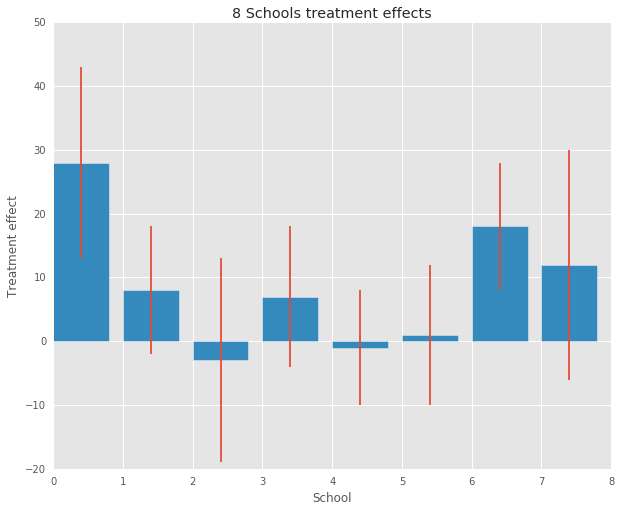

In [2]:
num_schools = 8  # number of schools
treatment_effects = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)  # treatment effects
treatment_stddevs = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)  # treatment SE

fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
fig.set_size_inches(10, 8)
plt.show()

# Model

To capture the data, we use a hierarchical normal model. It follows the generative process,

\begin{align*}
\mu &\sim \textrm{Normal}(0, 10) \\
\log \tau &\sim \textrm{Normal}(5, 1) \\
\theta_i &\sim \textrm{Normal}(\mu, (e^{\log\tau})^2) \\
y_j &\sim \textrm{Normal}(\theta_i, \sigma_{j}^2) \\
\end{align*}


where $\mu$ represents the prior average treatment effect and $\tau$ controls how much variance there is between schools. As $\tau \rightarrow \infty$, the model approaches the no-pooling model, i.e., each of the school treatment effect estimates are allowed to be more independent. As $\tau \rightarrow 0$, the model approaches the complete-pooling model, i.e., all of the school treatment effects are closer to the group average $\mu$. To restrict the standard deviation to be positive, we draw $\tau$ from a lognormal distribution (which is equivalent to drawing $log(\tau)$ from a normal distribution).

Following [Diagnosing Biased Inference with Divergences](http://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html), we transform the model above into an equivalent non-centered model:

\begin{align*}
\mu &\sim \textrm{Normal}(0, 10) \\
\log \tau &\sim \textrm{Normal}(5, 1) \\
\theta^{\prime}_{i} &\sim \textrm{Normal}(0,1) \\
\theta_i &\sim \mu + (e^{\log\tau})\theta^{\prime}_{i} \\
y_j &\sim \textrm{Normal}(\theta_i, \sigma_{j}^2) \\
\end{align*}

We reify this model as an Edward2 program:

In [0]:
def schools_model(num_schools, treatment_stddevs):
  avg_effect = ed.Normal(loc=0., scale=10., name="avg_effect")  # `mu` above
  avg_stddev = ed.Normal(
      loc=5., scale=1., name="avg_stddev")  # `log(tau)` above
  school_effects_standard = ed.Normal(
      loc=tf.zeros(num_schools),
      scale=tf.ones(num_schools),
      name="school_effects_standard")  # `theta_prime` above
  school_effects = avg_effect + tf.exp(
      avg_stddev) * school_effects_standard  # `theta` above
  treatment_effects = ed.Normal(
      loc=school_effects, scale=treatment_stddevs,
      name="treatment_effects")  # `y` above
  return treatment_effects

# Wrap model in a template. All calls to the model template will use the same
# TensorFlow variables.
model_template = tf.make_template("schools_model", schools_model)
log_joint = ed.make_log_joint_fn(model_template)


def target_log_prob_fn(avg_effect, avg_stddev, school_effects_standard):
  """Unnormalized target density as a function of states."""
  return log_joint(
      num_schools=num_schools,
      treatment_stddevs=treatment_stddevs,
      avg_effect=avg_effect,
      avg_stddev=avg_stddev,
      school_effects_standard=school_effects_standard,
      treatment_effects=treatment_effects)

# Bayesian Inference

Given data, we perform Hamiltonian Monte Carlo (HMC) to calculate the posterior distribution over the model's parameters.

In [6]:
num_results = 5000
num_burnin_steps = 3000

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=[
        tf.zeros([], name='init_avg_effect'),
        tf.zeros([], name='init_avg_stddev'),
        tf.ones([num_schools], name='init_school_effects_standard'),
    ],
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=0.4,
        num_leapfrog_steps=3))

avg_effect, avg_stddev, school_effects_standard = states

with tf.Session() as sess:
  [
      avg_effect_,
      avg_stddev_,
      school_effects_standard_,
      is_accepted_,
  ] = sess.run([
      avg_effect,
      avg_stddev,
      school_effects_standard,
      kernel_results.is_accepted,
  ])

school_effects_samples = (
    avg_effect_[:, np.newaxis] +
    np.exp(avg_stddev_)[:, np.newaxis] * school_effects_standard_)
num_accepted = np.sum(is_accepted_)
print('Acceptance rate: {}'.format(num_accepted / num_results))

Acceptance rate: 0.6244


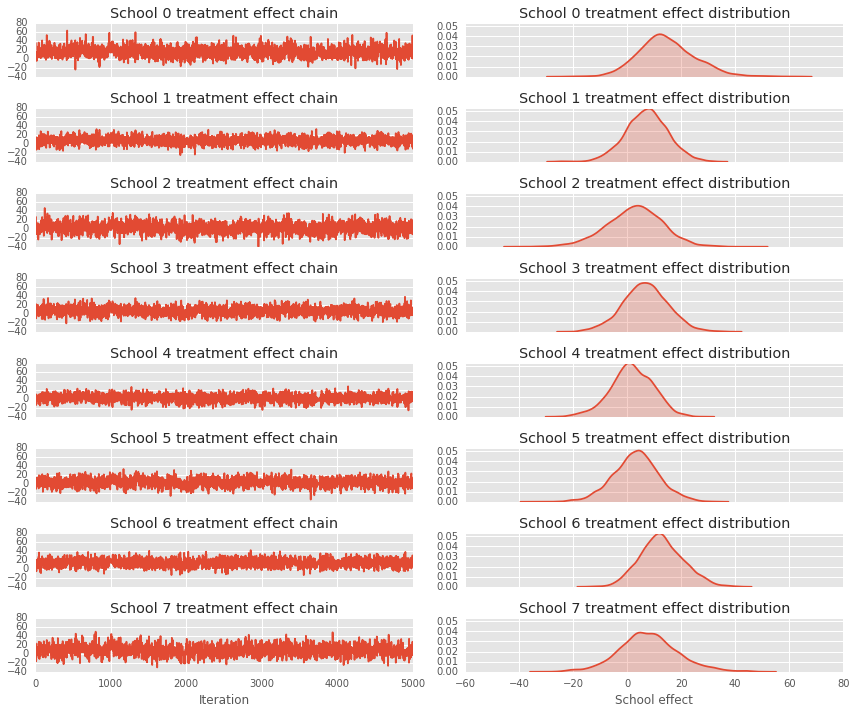

In [7]:
fig, axes = plt.subplots(8, 2, sharex='col', sharey='col')
fig.set_size_inches(12, 10)
for i in range(num_schools):
  axes[i][0].plot(school_effects_samples[:,i])
  axes[i][0].title.set_text("School {} treatment effect chain".format(i))
  sns.kdeplot(school_effects_samples[:,i], ax=axes[i][1], shade=True)
  axes[i][1].title.set_text("School {} treatment effect distribution".format(i))
axes[num_schools - 1][0].set_xlabel("Iteration")
axes[num_schools - 1][1].set_xlabel("School effect")
fig.tight_layout()
plt.show()

In [8]:
print("E[avg_effect] = {}".format(avg_effect_.mean()))
print("E[avg_stddev] = {}".format(avg_stddev_.mean()))
print("E[school_effects_standard] =")
print(school_effects_standard_[:, ].mean(0))
print("E[school_effects] =")
print(school_effects_samples[:, ].mean(0))

E[avg_effect] = 5.85305309296
E[avg_stddev] = 2.44214892387
E[school_effects_standard] =
[ 0.6585744   0.10054276 -0.24484468  0.06578837 -0.33857477 -0.20127961
  0.54620916  0.13560827]
E[school_effects] =
[ 14.68725014   7.17435408   2.71197844   6.66645861   1.74418437
   3.21988058  12.8004427    7.89747334]


In [0]:
# Compute the 95% interval for school_effects
school_effects_low = np.array([
    np.percentile(school_effects_samples[:, i], 2.5) for i in range(num_schools)
])
school_effects_med = np.array([
    np.percentile(school_effects_samples[:, i], 50) for i in range(num_schools)
])
school_effects_hi = np.array([
    np.percentile(school_effects_samples[:, i], 97.5)
    for i in range(num_schools)
])

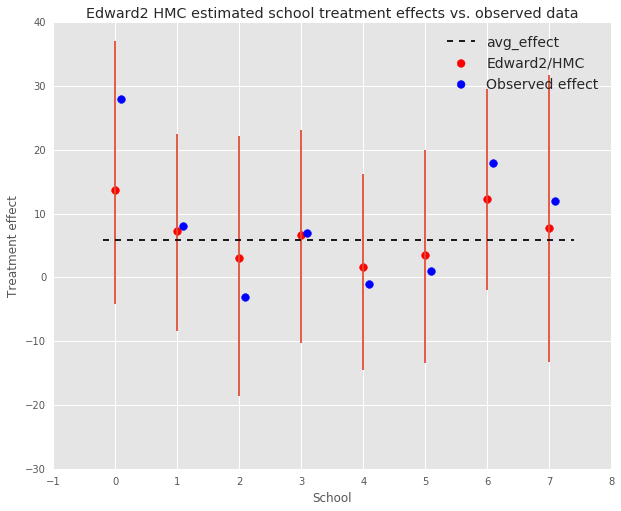

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
ax.scatter(np.array(range(num_schools)), school_effects_med, color='red', s=60)
ax.scatter(
    np.array(range(num_schools)) + 0.1, treatment_effects, color='blue', s=60)

avg_effect = avg_effect_.mean()

plt.plot([-0.2, 7.4], [avg_effect, avg_effect], 'k', linestyle='--')

ax.errorbar(
    np.array(range(8)),
    school_effects_med,
    yerr=[
        school_effects_med - school_effects_low,
        school_effects_hi - school_effects_med
    ],
    fmt='none')

ax.legend(('avg_effect', 'Edward2/HMC', 'Observed effect'), fontsize=14)

plt.xlabel('School')
plt.ylabel('Treatment effect')
plt.title('Edward2 HMC estimated school treatment effects vs. observed data')
fig.set_size_inches(10, 8)
plt.show()

We can observe the shrinkage toward the group `avg_effect` above.

In [11]:
print("Inferred posterior mean: {0:.2f}".format(
    np.mean(school_effects_samples[:,])))
print("Inferred posterior mean se: {0:.2f}".format(
    np.std(school_effects_samples[:,])))

Inferred posterior mean: 7.11
Inferred posterior mean se: 10.13


# Criticism

To get the posterior predictive distribution, i.e., a model of new data $y^*$ given the observed data $y$:

$$ p(y^*|y) \propto \int_\theta p(y^* | \theta)p(\theta |y)d\theta$$

we "intercept" the values of the random variables in the model to set them to the mean of the posterior distribution and sample from that model to generate new data $y^*$.

In [0]:
def interceptor(rv_constructor, *rv_args, **rv_kwargs):
  """Replaces prior on effects with empirical posterior mean from MCMC."""
  name = rv_kwargs.pop("name")
  if name == "avg_effect":
    rv_kwargs["value"] = np.mean(avg_effect_, 0)
  elif name == "avg_stddev":
    rv_kwargs["value"] = np.mean(avg_stddev_, 0)
  elif name == "school_effects_standard":
    rv_kwargs["value"] = np.mean(school_effects_standard_, 0)
  return rv_constructor(*rv_args, **rv_kwargs)


with ed.interception(interceptor):
  posterior = schools_model(
      num_schools=num_schools, treatment_stddevs=treatment_stddevs)

with tf.Session() as sess:
  posterior_predictive = sess.run(
      posterior.distribution.sample(sample_shape=(5000)))

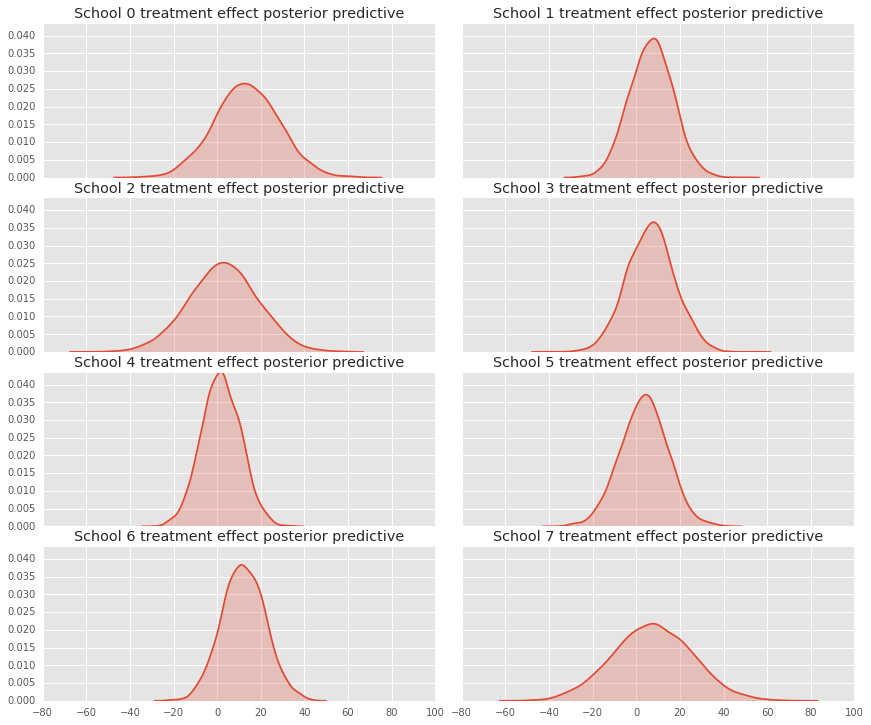

In [13]:
fig, axes = plt.subplots(4, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 10)
fig.tight_layout()
for i, ax in enumerate(axes):
  sns.kdeplot(posterior_predictive[:, 2*i], ax=ax[0], shade=True)
  ax[0].title.set_text(
      "School {} treatment effect posterior predictive".format(2*i))
  sns.kdeplot(posterior_predictive[:, 2*i + 1], ax=ax[1], shade=True)
  ax[1].title.set_text(
      "School {} treatment effect posterior predictive".format(2*i + 1))
plt.show()

In [0]:
# The mean predicted treatment effects for each of the eight schools.
prediction = posterior_predictive.mean(axis=0)

We can look at the residuals between the treatment effects data and the predictions of the model posterior. These correspond with the plot above which shows the shrinkage of the estimated effects toward the population average.

In [15]:
treatment_effects - prediction

array([ 14.40093136,   1.02613688,  -5.88324356,   0.32919693,
        -2.84093523,  -2.54369497,   5.84970093,   4.44477749], dtype=float32)

Because we have a distribution of predictions for each school, we can consider the distribution of residuals as well.

In [0]:
residuals = treatment_effects - posterior_predictive

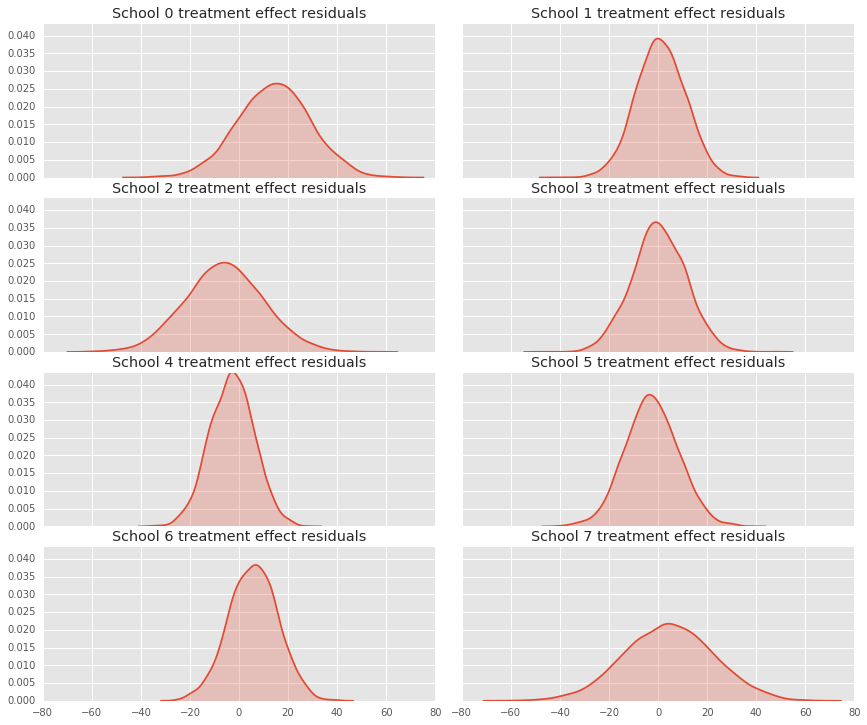

In [17]:
fig, axes = plt.subplots(4, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 10)
fig.tight_layout()
for i, ax in enumerate(axes):
  sns.kdeplot(residuals[:, 2*i], ax=ax[0], shade=True)
  ax[0].title.set_text(
      "School {} treatment effect residuals".format(2*i))
  sns.kdeplot(residuals[:, 2*i + 1], ax=ax[1], shade=True)
  ax[1].title.set_text(
      "School {} treatment effect residuals".format(2*i + 1))
plt.show()

# Acknowledgements

This tutorial was originally written in Edward 1.0 ([source](https://github.com/blei-lab/edward/blob/master/notebooks/eight_schools.ipynb)). We thank all contributors to writing and revising that version.

# References
1. Donald B. Rubin. Estimation in parallel randomized experiments. Journal of Educational Statistics, 6(4):377-401, 1981.
2. Andrew Gelman, John Carlin, Hal Stern, David Dunson, Aki Vehtari, and Donald Rubin. Bayesian Data Analysis, Third Edition. Chapman and Hall/CRC, 2013.